I use a linear regression model with 6 regressors to predict the production quantity. The first four regressors are the given parameters of precipitation, soil, temperature and the NDVI index, all of which are converted into monthly. To avoid ommited variable bias, I also include two more dummy regressors, region and month. The inclusion of region variable is to account for regional-specific attributes that do not necessarily change over time. Since the production quantities depend on seasons, it is important to include the month as another regressor. 


In [ ]:
# Upload the all packages and upload data 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

! git clone https://github.com/sabdi12/Yield-Model.git

fatal: destination path 'Yield-Model' already exists and is not an empty directory.


In [ ]:
# Load the data
precip = pd.read_csv('/content/Yield-Model/Daily Precipitation.csv')
soil = pd.read_csv('/content/Yield-Model/Daily Soil Mositure.csv')
temp = pd.read_csv('/content/Yield-Model/Daily Temperature.csv')
ndvi = pd.read_csv('/content/Yield-Model/Eight Day NDVI.csv')
quantity = pd.read_csv('/content/Yield-Model/Production Quantity.csv')
predt = pd.read_csv('/content/Yield-Model/predicted_production_qty.csv')

# Since we need to predict a monthly output, I first transform all the variables into monthly by mean.

# Convert daily rain frequency to monthly

precip['end_date'] = pd.to_datetime(precip['end_date'])
precip['month'] = pd.DatetimeIndex(precip['end_date']).month
precip = precip.set_index(['end_date', 'region_id'])
precip  = precip.groupby([pd.Grouper(level='region_id'),
                     pd.Grouper(level='end_date', freq='1M')]
                    ).mean()

# Convert the daily soil data into monthly
soil['end_date'] = pd.to_datetime(soil['end_date'])
soil['month'] = pd.DatetimeIndex(soil['end_date']).month
soil = soil.set_index(['end_date', 'region_id'])
soil  = soil.groupby([pd.Grouper(level='region_id'),
                     pd.Grouper(level='end_date', freq='1M')]
                    ).mean()

# Convert the temperature into monthly data

temp['end_date'] = pd.to_datetime(temp['end_date'])
temp['month'] = pd.DatetimeIndex(temp['end_date']).month
temp = temp.set_index(['end_date', 'region_id'])
temp  = temp.groupby([pd.Grouper(level='region_id'),
                     pd.Grouper(level='end_date', freq='1M')]
                    ).mean()

# Convert the ndvi index into monthly
ndvi['end_date'] = pd.to_datetime(ndvi['end_date'])
ndvi['month'] = pd.DatetimeIndex(ndvi['end_date']).month
ndvi = ndvi.set_index(['end_date','region_id'])
ndvi = ndvi.groupby([pd.Grouper(level='region_id'),
                     pd.Grouper(level='end_date', freq='1M')]
                    ).mean()
                    
# Combine the feature columns and create a column for region
data = pd.concat([precip,soil['smos'],temp['temp'],ndvi['ndvi']], axis = 1, ignore_index=False, sort = False)
data = data.fillna(0)
data['region'] = data.index.get_level_values('region_id') 



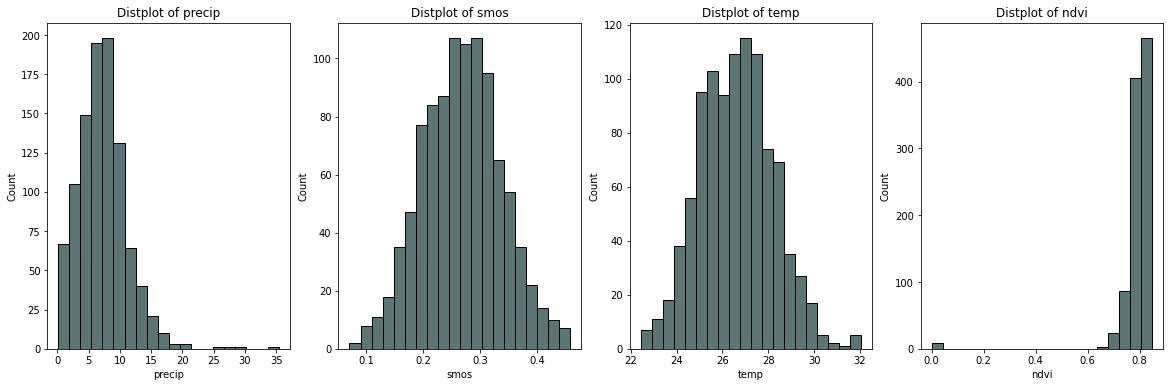

In [ ]:
# Data Exploratory

# Check for outliers by looking at the distribution of variables
fig, ax = plt.subplots(1,4,figsize=(20,6))
n = 0
for x in ['precip','smos','temp', 'ndvi']:
    sns.histplot(data[x],bins=20,color='#244747',ax=ax[n])
    ax[n].set_title('Distplot of {}'.format(x))
    n+=1
plt.show()

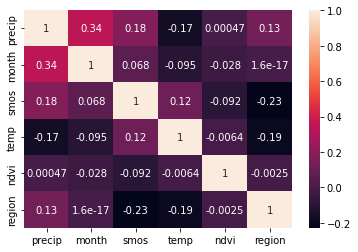

In [ ]:
# Check the correlation between variables for possible multi-collinearity
corrdata = data.corr()
sns.heatmap(corrdata, annot=True)
plt.show()

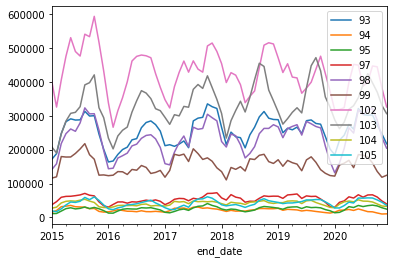

In [ ]:
# Check for a strong trend in the quantity production across regions over time. 
quantity['end_date'] = pd.to_datetime(quantity['end_date'])
quantity = quantity.set_index('end_date')
quantity.groupby('region_id')['prod'].plot(legend=True)
plt.show()

In [ ]:
# Standarize the numerical columns of the data
cols = ['precip', 'smos', 'temp', 'ndvi']
s = data[cols].values
scaler = StandardScaler().fit(s)
n_data = scaler.transform(s)
df_temp = pd.DataFrame(n_data, columns=cols, index = data.index)
data[cols] = df_temp

In [ ]:
# Create dummy variables for each region and each month of the year. 

data = pd.get_dummies(data , prefix=None, 
                       prefix_sep='_', dummy_na=False, columns= ['month', 'region'], 
                       sparse=False, drop_first=False, dtype=None)

# Create the data set that will be used to train the regression
index1 = pd.date_range(start='2015-01-31', end='2020-12-31', freq = "M")
X_train = data.loc[pd.IndexSlice[:,index1], :]

# Create the test data set from Jan 2021 to Dec 2021 that will be used for prediction

index2 = pd.date_range(start='2021-01-31', end='2021-12-31', freq = "M")
X_test = data.loc[pd.IndexSlice[:,index2], :]

Y = quantity.drop(['start_date', 'region_id'], axis = 1)


In [ ]:
# Train the model on the data and use it to predict the quantity from Jan 2021 to Dec 2021
model = linear_model.LinearRegression()
model.fit(X_train, Y)
Y_pred = model.predict(X_test)

In [ ]:
predt['prod'] = Y_pred
predt.to_csv('saeedhassan414@gmail.com.csv', index=False)
